In [2]:
# Adjust the import according to what you installed
import gymnasium as gym

# Attempt to create and reset an environment
env = gym.make('CartPole-v1')  # Ensure 'CartPole-v1' is available in the installed package
env.reset()
print("Environment is ready.")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import random

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

import sys
sys.path.append("../")

import os 
import optuna

from mbt_gym.agents.SbAgent import SbAgent

from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.agents.BaselineAgents import AvellanedaStoikovAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import PnL, CjMmCriterion, RunningInventoryPenalty
from mbt_gym.stochastic_processes.midprice_models import BrownianMotionMidpriceModel, BrownianMotionJumpMidpriceModel
from mbt_gym.stochastic_processes.arrival_models import PoissonArrivalModel, HawkesArrivalModel
from mbt_gym.stochastic_processes.fill_probability_models import ExponentialFillFunction
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics
from mbt_gym.gym.backtesting import get_sharpe_ratio
from mbt_gym.gym.helpers.plotting import generate_trajectory, generate_results_table_and_hist, plot_trajectory, plot_stable_baselines_actions

import importlib

Environment is ready.


In [3]:
terminal_time = 1.0
arrival_rate = 10.0
n_steps = int(100 * terminal_time * arrival_rate)
phi = 0.5
alpha = 0.001

In [4]:
# Different Markets
initial_prices = [1, 100, 1000, 10000, 50000]
sigmas = [1, 0.5, 0.2, 0.05, 0.01]
jump_sizes = [1, 1, 1, 1, 1]

In [13]:
def get_Hk_OF(_sigma_, _initial_price_, _jump_size_, num_trajectories:int = 1):#, initial_inventory_range:tuple = ((0, 1000), (-2, 2))):
    fill_exponent = 1
    sigma = _sigma_
    initial_price = _initial_price_
    step_size = 1/n_steps
    jump_size = _jump_size_
    timestamps = np.linspace(0, terminal_time, n_steps + 1)

    initial_inventory = (0,1) # 0$ in cash and 1$ dollars in stock
    # Randomize initial inventory
    # initial_cash = random.uniform(*initial_inventory_range[0])
    # initial_stock = random.uniform(*initial_inventory_range[1])
    # initial_inventory = (initial_cash, initial_stock)

    midprice_model = BrownianMotionJumpMidpriceModel(volatility=sigma, step_size=1/n_steps, jump_size=jump_size,
                                                 num_trajectories=num_trajectories)
    
    # I should maybe specify the baseline rate
    arrival_model = HawkesArrivalModel(step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    reward_function = RunningInventoryPenalty(per_step_inventory_aversion = phi, terminal_inventory_aversion = alpha)

    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=n_steps,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      reward_function = reward_function,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [18]:
# Add directory for tensorboard logging and best model
base_tensorboard_logdir = "./ppo/"
best_model_path = "./SB_models/PPO-best-CJ"
agent_name = "PPO"
tensorboard_logdir = os.path.join(base_tensorboard_logdir, agent_name)

# Initialize the model outside the loop
policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])]) # two hidden layers containing 256 units each for policy network and value function

# Initialize a dummy environment for initial model setup (you can replace it with one of your environments)
dummy_env = get_Hk_OF(sigmas[0], initial_prices[0], jump_sizes[0], num_trajectories=100)
sb_dummy_env = StableBaselinesTradingEnvironment(trading_env=dummy_env)
sb_dummy_env = VecMonitor(sb_dummy_env)

PPO_params = {
    "policy": 'MlpPolicy', 
    "env": sb_dummy_env,
    "verbose": 1, 
    "policy_kwargs": policy_kwargs, 
    "tensorboard_log": tensorboard_logdir,
    "n_epochs": 5, 
    "batch_size": int(n_steps * 100 / 10), 
    "n_steps": int(n_steps)
}

model = PPO(**PPO_params, device="cpu")

# Training across different environments
for i in range(len(initial_prices)):
    num_trajectories = 100
    initial_price = initial_prices[i]
    sigma = sigmas[i]
    jump_size = jump_sizes[i]
    
    # Create new environment for each iteration
    env = get_Hk_OF(sigma, initial_price, jump_size, num_trajectories)
    sb_env = StableBaselinesTradingEnvironment(trading_env=env)
    sb_env = VecMonitor(sb_env)
    
    # Update the model's environment
    model.set_env(sb_env)
    
    # Define callback for saving the best model
    callback_params = {
        "eval_env": sb_env, 
        "n_eval_episodes": 2048, 
        "best_model_save_path": best_model_path, 
        "deterministic": True
    }
    callback = EvalCallback(**callback_params)
    
    # Continue training the model
    model.learn(total_timesteps=5_000_000, callback=callback)

Using cpu device
Logging to ./ppo/PPO\PPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -228     |
| time/              |          |
|    fps             | 63996    |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 100000   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -228         |
| time/                   |              |
|    fps                  | 35327        |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 200000       |
| train/                  |              |
|    approx_kl            | 0.0029628996 |
|    clip_fraction        | 0.0132       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained

ValueError: Observation spaces do not match: Box([-1.04e+05 -1.00e+03  0.00e+00  9.60e+01  0.00e+00  0.00e+00], [1.04e+05 1.00e+03 1.00e+00 1.04e+02 1.00e+02 1.00e+02], (6,), float32) != Box([-1.02e+05 -1.00e+03  0.00e+00  9.80e+01  0.00e+00  0.00e+00], [1.02e+05 1.00e+03 1.00e+00 1.02e+02 1.00e+02 1.00e+02], (6,), float32)

In [ ]:
model.learn(total_timesteps = 20_000_000)  # Increase number of training timesteps according to computing resources

Logging to ./ppo_tensorboard/jump = 1, sigma = 2, epoch 5\PPO_2


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -254     |
| time/              |          |
|    fps             | 288542   |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 1000000  |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -201        |
| time/                   |             |
|    fps                  | 54683       |
|    iterations           | 2           |
|    time_elapsed         | 36          |
|    total_timesteps      | 2000000     |
| train/                  |             |
|    approx_kl            | 0.002633208 |
|    clip_fraction        | 0.00948     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | 0.00211     |
|    learning_rate        | 0.

In [ ]:
ppo_agent = SbAgent(model)

observations, actions, rewards = generate_trajectory(sb_env, ppo_agent)

# Squeeze for the dimenson
rewards = np.squeeze(rewards, axis=1)

# Disregard the end value of observation (starting env)
observations = observations[:,:,:-1]

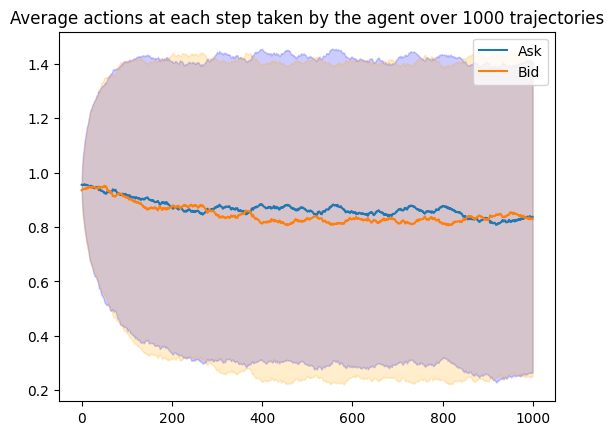

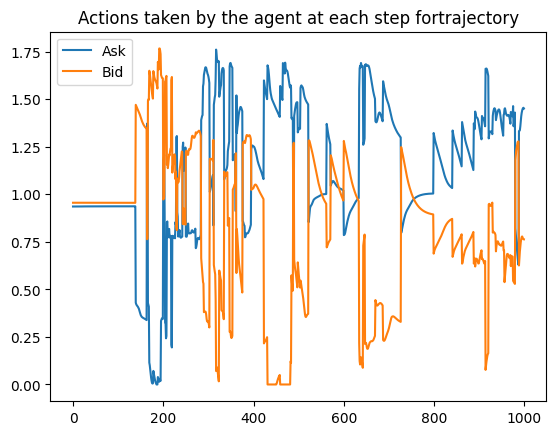

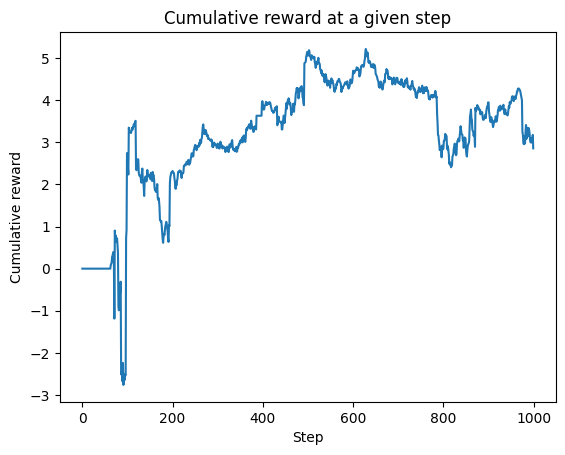

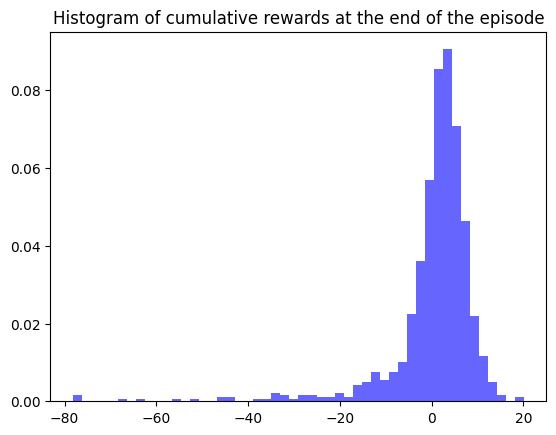

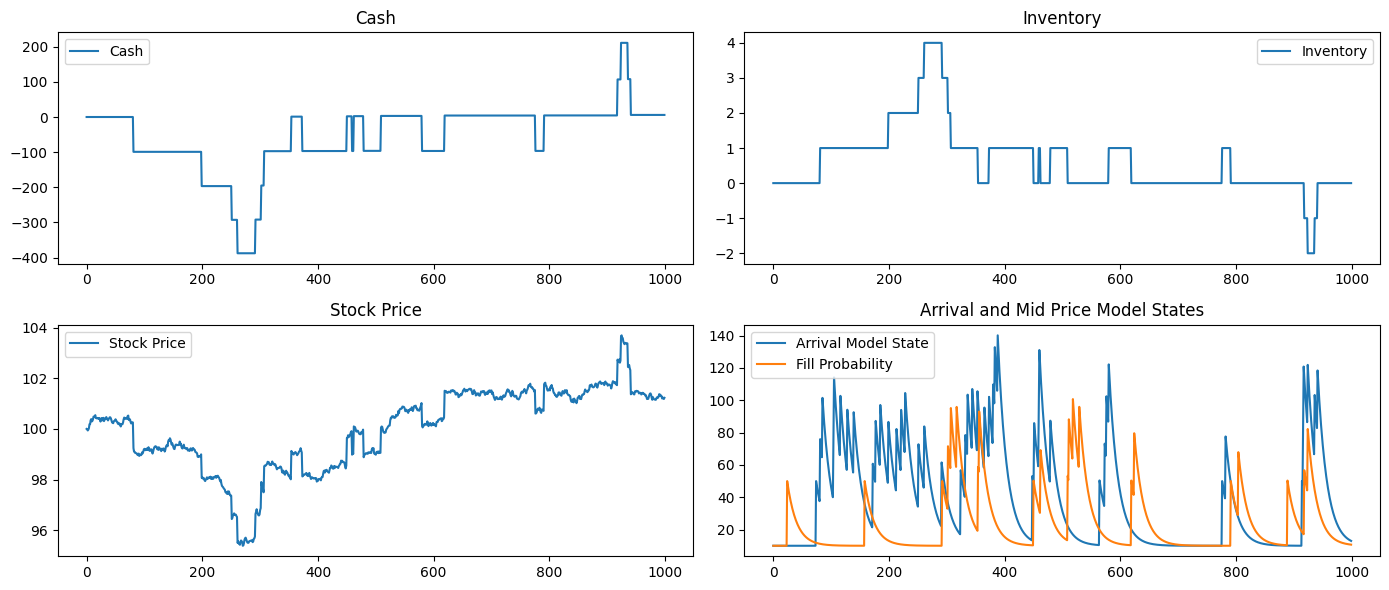

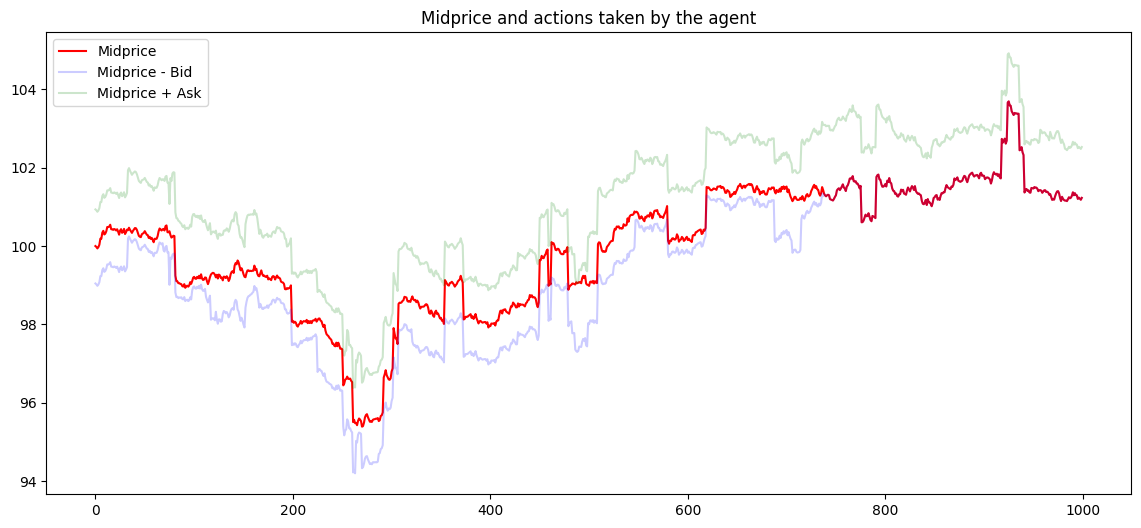

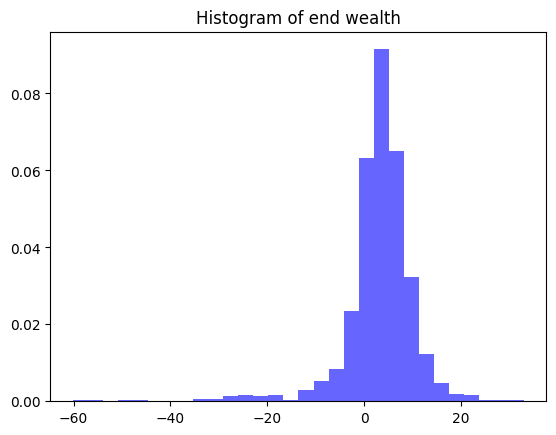

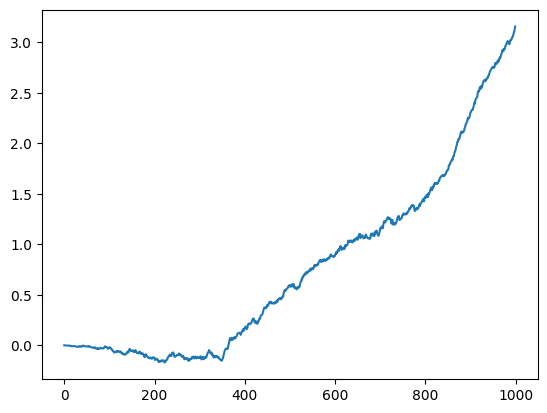

In [ ]:
mean_actions_ask = actions[:,0,:].mean(axis=0)
mean_actions_bid = actions[:,1,:].mean(axis=0)

std_ask = actions[:,0,:].std(axis=0)
std_bid = actions[:,1,:].std(axis=0)

mean_actions_ask.shape
mean_actions_bid.shape

plt.plot(mean_actions_ask, label = "Ask")
plt.plot(mean_actions_bid, label = "Bid")
plt.fill_between(np.arange(0, n_steps), mean_actions_ask - std_ask , mean_actions_ask + std_ask , color = 'blue', alpha = 0.2)
plt.fill_between(np.arange(0, n_steps), mean_actions_bid - std_bid , mean_actions_bid + std_bid , color = 'orange', alpha = 0.2)

plt.title("Average actions at each step taken by the agent over 1000 trajectories")
plt.legend()
plt.show()

plt.plot(actions[500,1,:], label = "Ask")
plt.plot(actions[500,0,:], label= "Bid")
plt.title("Actions taken by the agent at each step fortrajectory")
plt.legend()
plt.show()

cum_rewards = np.cumsum(rewards, axis=-1)

plt.plot(cum_rewards[200])
plt.title("Cumulative reward at a given step")
plt.xlabel("Step")
plt.ylabel("Cumulative reward")
plt.show()

plt.hist(cum_rewards[:,-1], bins = 50, density = True, alpha = 0.6, color = 'b')
plt.title("Histogram of cumulative rewards at the end of the episode")
plt.show()


j = 666

# Create a 3x2 panel for plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

# Plot different features in each subplot
axes[0, 0].plot(observations[j, 0, :], label='Cash')
axes[0, 0].set_title('Cash')
axes[0, 0].legend()

axes[0, 1].plot(observations[j, 1, :], label='Inventory')
axes[0, 1].set_title('Inventory')
axes[0, 1].legend()

axes[1, 0].plot(observations[j, 3, :], label='Stock Price')
axes[1, 0].set_title('Stock Price')
axes[1, 0].legend()

axes[1, 1].plot(observations[j, 4, :], label='Arrival Model State')
axes[1, 1].plot(observations[j, 5, :], label='Fill Probability')
axes[1, 1].set_title('Arrival and Mid Price Model States')
axes[1, 1].legend()

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(observations[j, 3, :], label = "Midprice", color = 'red')
         
plt.plot(observations[j, 3, :] - actions[0, 0, :], label = "Midprice - Bid", color = 'blue', alpha = 0.2)
plt.plot(observations[j, 3, :] + actions[0, 1, :], label = "Midprice + Ask", color = 'green', alpha = 0.2)
plt.title("Midprice and actions taken by the agent")
plt.legend()    
plt.show()


endmoney = observations[:, 1, :] * observations[:, 3, :] + observations[:, 0, :]

plt.hist(endmoney[:,-1], bins = 30, density = True, alpha = 0.6, color = 'b')
plt.title("Histogram of end wealth")
plt.show()

mean_wealth = endmoney.mean(axis=0)

plt.plot(mean_wealth)

We plot the result for the worst scenerio

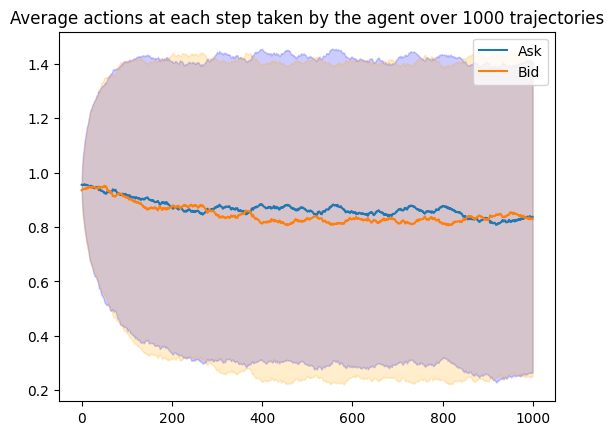

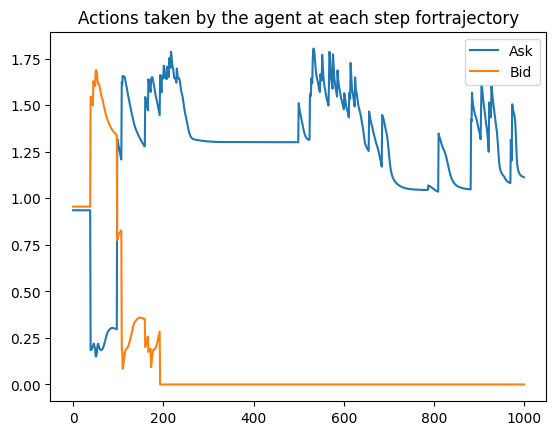

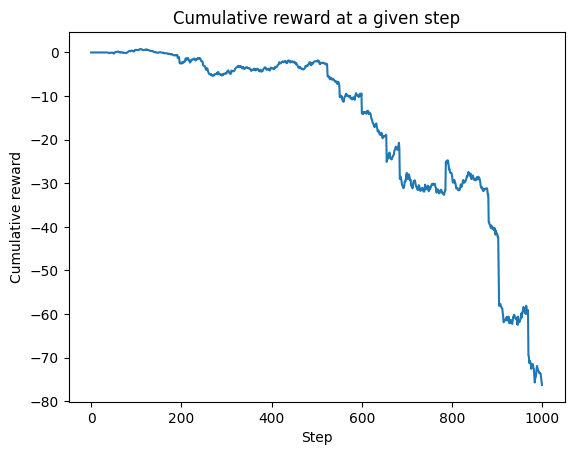

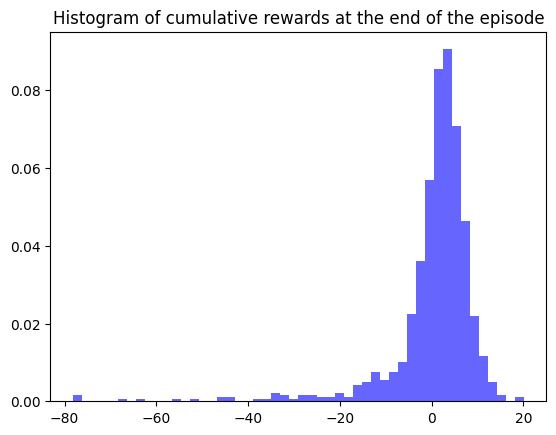

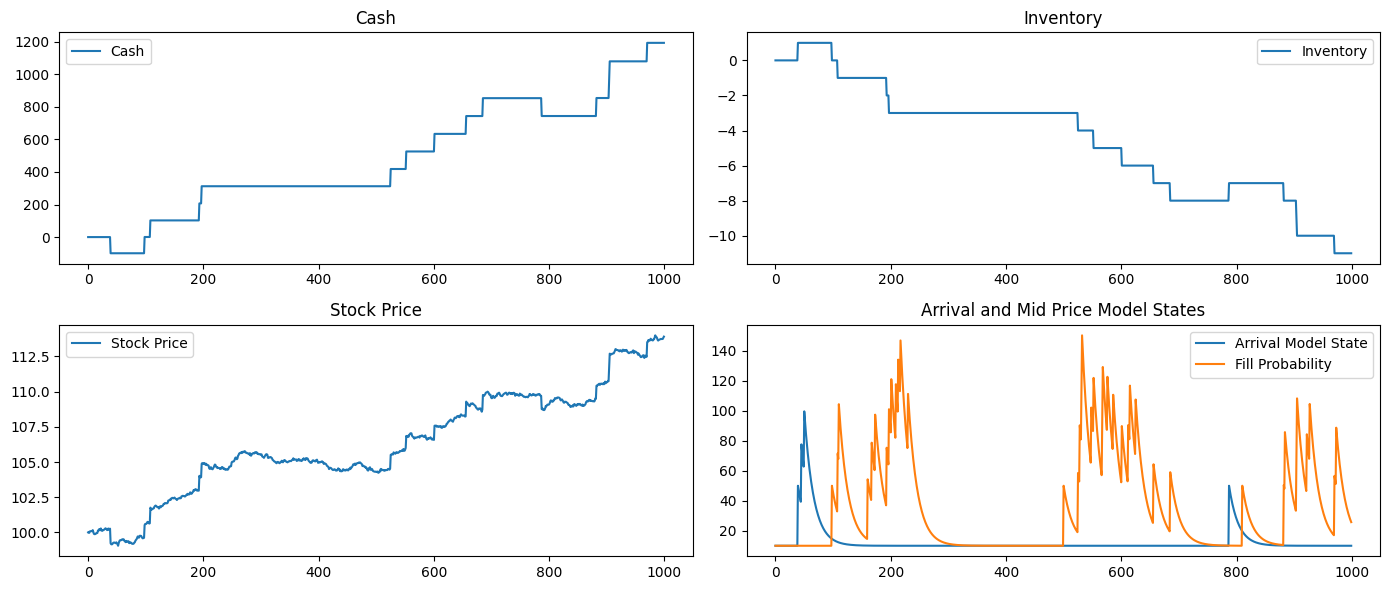

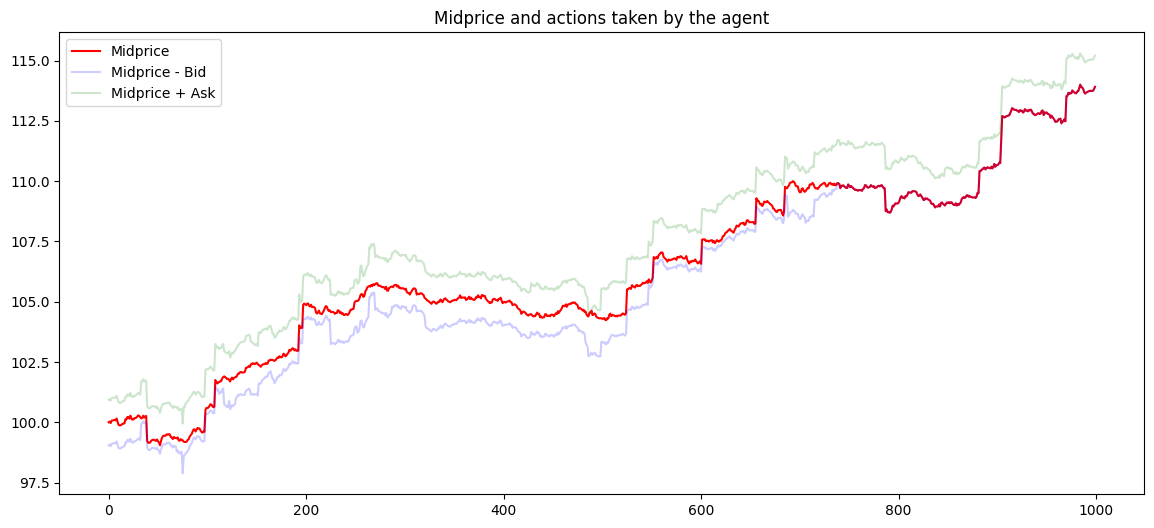

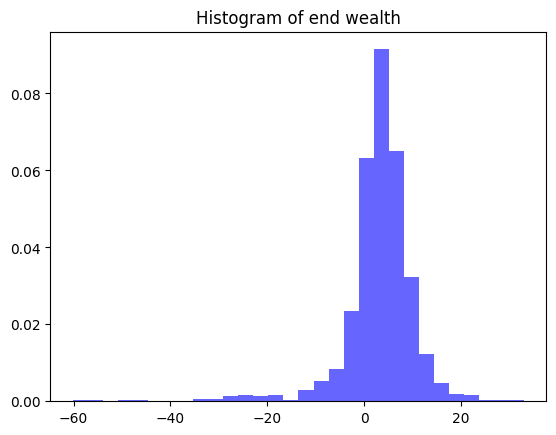

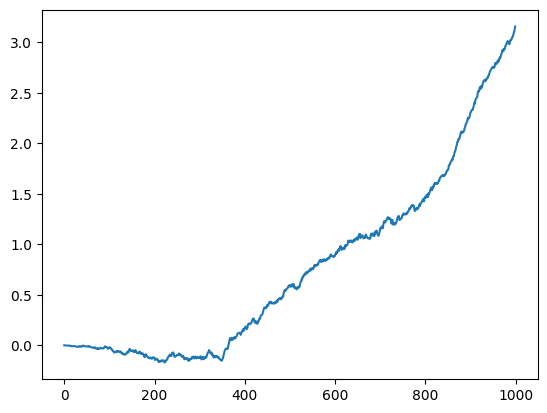

In [ ]:
j = np.argmin(endmoney[:,-1])


mean_actions_ask = actions[:,0,:].mean(axis=0)
mean_actions_bid = actions[:,1,:].mean(axis=0)

std_ask = actions[:,0,:].std(axis=0)
std_bid = actions[:,1,:].std(axis=0)

mean_actions_ask.shape
mean_actions_bid.shape

plt.plot(mean_actions_ask, label = "Ask")
plt.plot(mean_actions_bid, label = "Bid")
plt.fill_between(np.arange(0, n_steps), mean_actions_ask - std_ask , mean_actions_ask + std_ask , color = 'blue', alpha = 0.2)
plt.fill_between(np.arange(0, n_steps), mean_actions_bid - std_bid , mean_actions_bid + std_bid , color = 'orange', alpha = 0.2)

plt.title("Average actions at each step taken by the agent over 1000 trajectories")
plt.legend()
plt.show()

plt.plot(actions[j,1,:], label = "Ask")
plt.plot(actions[j,0,:], label= "Bid")
plt.title("Actions taken by the agent at each step fortrajectory")
plt.legend()
plt.show()

cum_rewards = np.cumsum(rewards, axis=-1)

plt.plot(cum_rewards[j])
plt.title("Cumulative reward at a given step")
plt.xlabel("Step")
plt.ylabel("Cumulative reward")
plt.show()

plt.hist(cum_rewards[:,-1], bins = 50, density = True, alpha = 0.6, color = 'b')
plt.title("Histogram of cumulative rewards at the end of the episode")
plt.show()

# Create a 3x2 panel for plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

# Plot different features in each subplot
axes[0, 0].plot(observations[j, 0, :], label='Cash')
axes[0, 0].set_title('Cash')
axes[0, 0].legend()

axes[0, 1].plot(observations[j, 1, :], label='Inventory')
axes[0, 1].set_title('Inventory')
axes[0, 1].legend()

axes[1, 0].plot(observations[j, 3, :], label='Stock Price')
axes[1, 0].set_title('Stock Price')
axes[1, 0].legend()

axes[1, 1].plot(observations[j, 4, :], label='Arrival Model State')
axes[1, 1].plot(observations[j, 5, :], label='Fill Probability')
axes[1, 1].set_title('Arrival and Mid Price Model States')
axes[1, 1].legend()

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(observations[j, 3, :], label = "Midprice", color = 'red')
         
plt.plot(observations[j, 3, :] - actions[0, 0, :], label = "Midprice - Bid", color = 'blue', alpha = 0.2)
plt.plot(observations[j, 3, :] + actions[0, 1, :], label = "Midprice + Ask", color = 'green', alpha = 0.2)
plt.title("Midprice and actions taken by the agent")
plt.legend()    
plt.show()


endmoney = observations[:, 1, :] * observations[:, 3, :] + observations[:, 0, :]

plt.hist(endmoney[:,-1], bins = 30, density = True, alpha = 0.6, color = 'b')
plt.title("Histogram of end wealth")
plt.show()

mean_wealth = endmoney.mean(axis=0)

plt.plot(mean_wealth)